# Backpropagating values
The main idea here is that in the vicinity of a terminated trajectory (game) we can reasonably hope to find other trajectories that would also be terminated. We hope to overcome the problem of sparse rewards during RL training.

So we look at how we can generate training data for the value function from walking backward (using ```undo()```  from a game that has finally terminated in favour of one of the parties. 

In [38]:
import numpy as np

In [39]:
from wgomoku import (
    GomokuBoard, HeuristicGomokuPolicy, Heuristics, ThreatSearch,
    StochasticMaxSampler, GomokuTools as gt)

In [40]:
heuristics = Heuristics(kappa=3.0)
ts = ThreatSearch(max_depth=6, max_width=5)
p = HeuristicGomokuPolicy(bias=.5,topn=5, style=2, threat_search=ts)

In [41]:
A,B,C,D,E,F,G,H,I, J, K, L, M, N, O, P, Q, R, S, T, U = \
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK, WHITE, EDGES = 0,1,2

In [42]:
import pandas as pd
SIZE=19
df = pd.read_csv("newgames1.csv", header=None)
df.columns = ['board', 'win']
games = df['board']

In [43]:
stones = gt.string_to_stones(games[12])
board = GomokuBoard(disp_width=10, N=SIZE, heuristics= heuristics, stones = stones)

In [44]:
gt.stones_to_string(stones), board.game_state()

('j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14j15', 1)

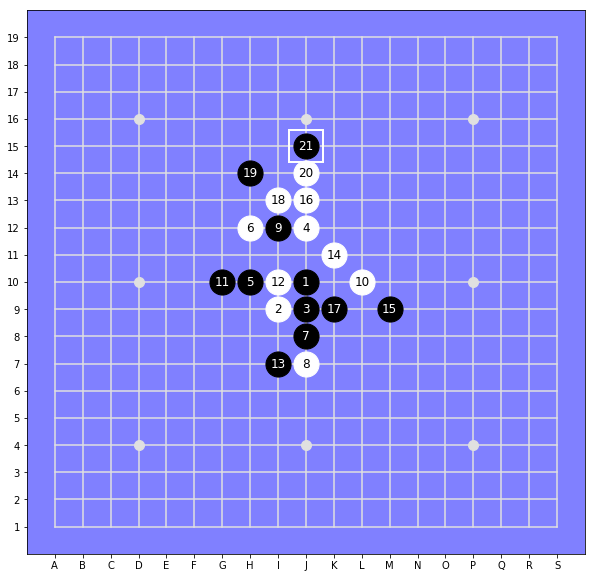

In [45]:
board.display()

In [46]:
from wgomoku import create_sample, to_matrix12

In [47]:
ts = ThreatSearch(max_depth=4, max_width=5)
p = HeuristicGomokuPolicy(bias=.5,topn=5, style=2, threat_search=ts)

In [48]:
p.suggest(board)

Win-in-2: (K, 15)

Register a board with its value. Duplicates are (silently ignored).

In [49]:
class ValueTracker:
    def __init__(self, policy):
        self.reg={}
        self.p = policy

    def register(self, board, value=0):
        """
        register a particular board and its value
        """
        size_before = len(self.reg)
        value = value or (board.game_state() or self.is_determined(board))
        if value != 0:
            stones = board.stones
            string = gt.stones_to_string(stones)
            sample = create_sample(stones, board.N, 1-board.current_color)
            h = hash(to_matrix12(sample, size=SIZE+2).tostring())
            self.reg[h] = [value, string] 
            
        return len(self.reg) - size_before
        
    def is_determined(self, board):
        enum = np.ndenumerate(p.probas(board=board, style=2))
        sampler = StochasticMaxSampler(enum, topn=10)
        choices = [ gt.m2b((x,y),SIZE) for _, (x,y), prob, _ in sampler.choices]
        states = []
        for x,y in choices:
            board.set(x,y)
            if self.fwd_value(board) != 0:
                states.append(self.fwd_value(board))
            else:
                states.append(board.game_state())
                if board.game_state():
                    self.register(board, board.game_state())
            board.undo(True)
        if (np.array(states) == 1).all():
            return -1
        elif (np.array(states) == -1).all():
            return 1
        else:
            return 0

    def fwd_value(self, board):
        """
        return the forward value if the board is already registered, 0 otherwise.
        """
        stones = board.stones
        sample = create_sample(stones, board.N, 1-board.current_color)
        h = hash(to_matrix12(sample, size=SIZE+2).tostring())
        return self.reg.get(h, (0, ""))[0]
        
    def __repr__(self):
        return str(list(self.reg.values()))
    


In [50]:
tracker = ValueTracker(p)

In [51]:
newboards = tracker.register(board)
tracker, newboards

([[1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14j15']], 1)

---
### One step back

0

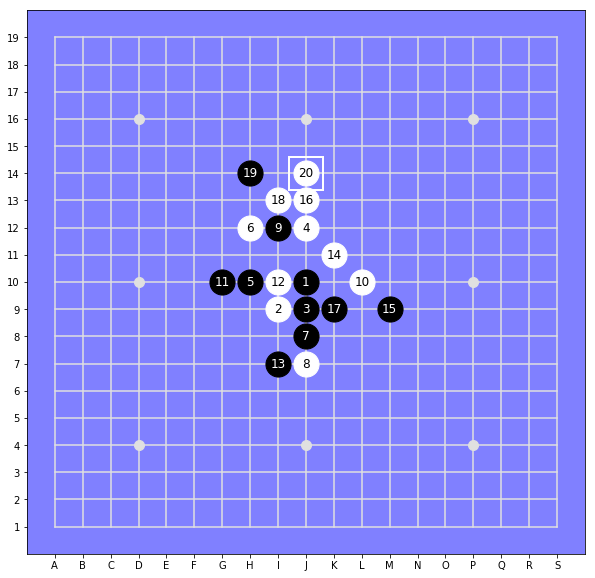

In [52]:
board.undo().display()
board.game_state()

In [53]:
enum = np.ndenumerate(p.probas(board=board, style=2))
sampler = StochasticMaxSampler(enum, topn=10)
choices = [ gt.m2b((x,y),SIZE) for _, (x,y), prob, _ in sampler.choices]
[(chr(x+64), y) for x,y in choices]

[('G', 11), ('K', 15), ('J', 15)]

If all possible moves lead to the same terminating outcome then the value before the move is just that same outcome. At the same time we record also the other terminating outcomes.

In [54]:
newboards = tracker.register(board)
tracker, newboards

([[-1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14k15'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14j15'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14g11']],
 3)

---
### And one more step back

0

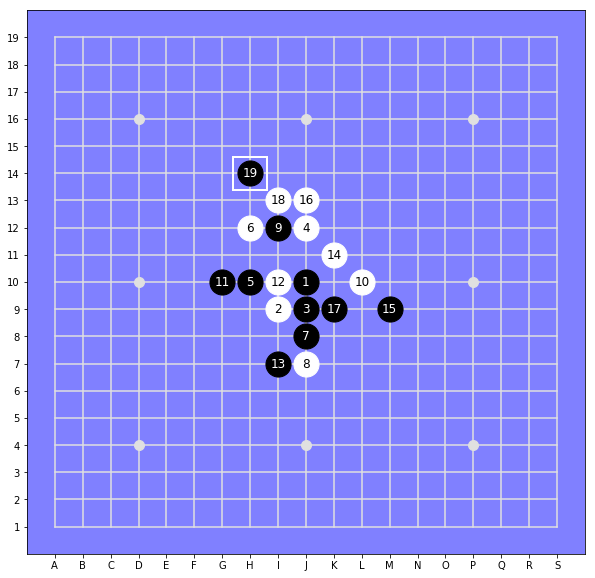

In [55]:
board.undo().display()
board.game_state()

In [56]:
enum = np.ndenumerate(p.probas(board=board, style=2))
sampler = StochasticMaxSampler(enum, topn=10)
choices = [ gt.m2b((x,y),SIZE) for _, (x,y), prob, _ in sampler.choices]
[(chr(x+64), y) for x,y in choices]

[('J', 14)]

In [57]:
newboards = tracker.register(board)
tracker, newboards

([[1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14'], [-1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14k15'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14j15'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14g11']],
 1)

The value of (J, 14) is zero, but we have the forward-looking value of (J, 14) already registered! So, if all possible moves lead to a board with a known value, the negative of that value is the value of the registered board.

0

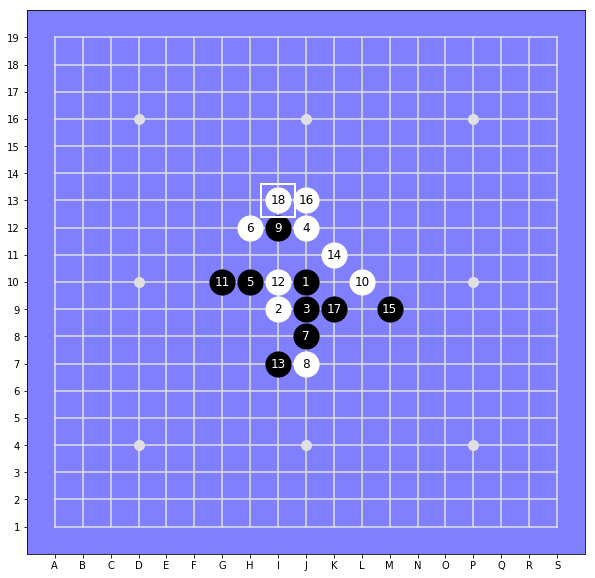

In [58]:
board.undo().display()
board.game_state()

In [59]:
enum = np.ndenumerate(p.probas(board=board, style=2))
sampler = StochasticMaxSampler(enum, topn=10)
choices = [ gt.m2b((x,y),SIZE) for _, (x,y), prob, _ in sampler.choices]
[(chr(x+64), y) for x,y in choices]

[('H', 14)]

In [60]:
newboards = tracker.register(board)
tracker, newboards

([[-1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14g11'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14k15'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14j15'], [-1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14']],
 1)

(0, (9, 13))

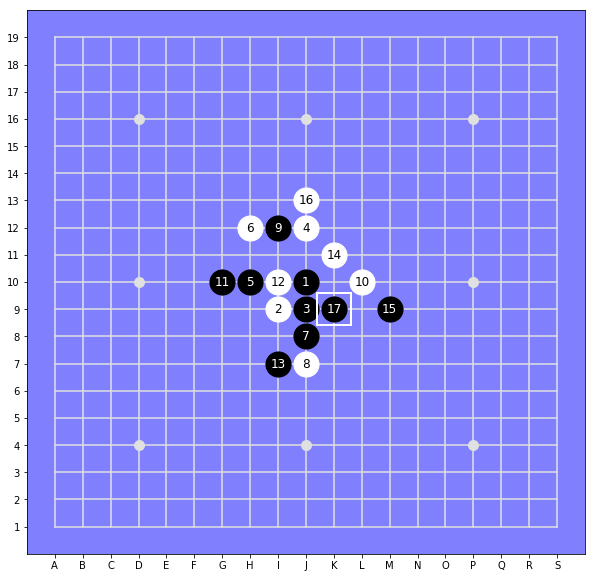

In [61]:
last_move = board.stones[-1]
board.undo().display()
board.game_state(), last_move

In [65]:
enum = np.ndenumerate(p.probas(board=board, style=2))
sampler = StochasticMaxSampler(enum, topn=10)
choices = [ gt.m2b((x,y),SIZE) for _, (x,y), prob, _ in sampler.choices]
[(chr(x+64), y) for x,y in choices]

[('L', 9),
 ('I', 13),
 ('L', 8),
 ('F', 10),
 ('J', 11),
 ('M', 7),
 ('H', 14),
 ('G', 5),
 ('H', 6),
 ('I', 11)]

In [66]:
newboards = tracker.register(board)
tracker, newboards

([[-1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14g11'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14k15'], [1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14j15'], [-1, 'j10i9j9j12h10h12j8j7i12l10g10i10i7k11m9j13k9i13h14j14']],
 0)

Now we have come to head of the threat sequence. Maybe some other options will also create threat sequences?

In [72]:
ts.is_tseq_won(board=board, max_depth=4, max_width=5)

([(9, 13), (8, 14), (10, 14), (10, 15), (7, 11)], True)

In [33]:
board.undo()

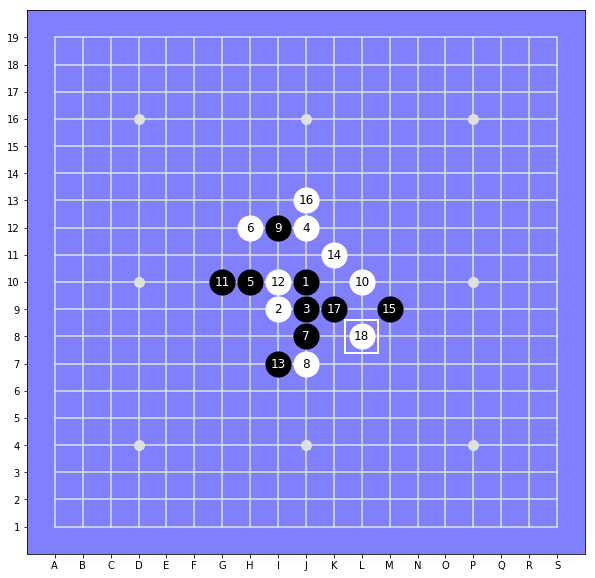

In [30]:
board.set(L,8).display()

In [31]:
p.suggest(board)

Defending lurking threat sequence: (I, 13)